# Data Loading

In [0]:

from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
import sparknlp
from sparknlp.annotator import DocumentAssembler, Tokenizer, RoBertaForZeroShotClassification, RoBertaEmbeddings
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from functools import reduce
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import UniversalSentenceEncoder
import torch
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

spark = SparkSession.builder.getOrCreate()

# Loading Reddit And Linkedin data
- profiles (provided by brightdata)
- companies (provided by brightdata)

- reddit posts from subreddit r/artifical
- reddit posts from subreddit r/hiring
- reddit posts from subreddit r/congrats
- reddit posts from subreddit r/datascience
- reddit posts from subreddit r/jobposting
- reddit posts from subreddit r/remotework
- reddit posts from subreddit r/unpopularopinion


In [0]:
companies = spark.read.parquet('/dbfs/linkedin_train_data')
profiles = spark.read.parquet('/dbfs/linkedin_people_train_data')
subreddit_artificial = spark.read.format('delta').load('/user/hive/warehouse/reddit_postsartificial_final_csv')
subreddit_tech_jobs = spark.read.format('delta').load('/user/hive/warehouse/reddit_poststechjobs_2_csv')
subrredit_postshiring = spark.read.format('delta').load('/user/hive/warehouse/reddit_postshiring_2_csv')
subrredit_postscongratslikeimfive = spark.read.format('delta').load('/user/hive/warehouse/reddit_postscongratslikeimfive_csv')
subrredit_postsdatascience = spark.read.format('delta').load('/user/hive/warehouse/reddit_postsdatascience_csv')
subrredit_postsjobpostings = spark.read.format('delta').load('/user/hive/warehouse/reddit_postsjobpostings_csv')
subrredit_postsremotework = spark.read.format('delta').load('/user/hive/warehouse/reddit_postsremotework_csv')
subrredit_postsunpopularopinion = spark.read.format('delta').load('/user/hive/warehouse/reddit_postsunpopularopinion_csv')

subrredit_postscarreradvice = spark.read.format('delta').load('/user/hive/warehouse/reddit_postscareeradvice_csv')
subrredit_postsmarketing = spark.read.format('delta').load('/user/hive/warehouse/reddit_postsmarketing_csv')

subrredit_postspersonalfinance = spark.read.format('delta').load('/user/hive/warehouse/reddit_postspersonalfinance_csv')

all_df = {
    "subreddit_AI": subreddit_artificial,
    "subreddit_Tech_jobs": subreddit_tech_jobs,
    "subreddit_Hiring": subrredit_postshiring,
    "subreddit_Achievement": subrredit_postscongratslikeimfive,
    "subreddit_DataScience": subrredit_postsdatascience,
    "subreddit_Job_posting": subrredit_postsjobpostings,
    "subreddit_Remotework": subrredit_postsremotework,
    "subreddit_Discussion": subrredit_postsunpopularopinion,
    "subreddit_Carrer_Advice": subrredit_postscarreradvice,
    "subreddit_Marketing": subrredit_postsmarketing,
    "subreddit_Finance": subrredit_postspersonalfinance

}

## Cleaning rows from scarped data
* removing duplicates and junk data

In [0]:
COUNT = 0
for df_key in all_df.keys():
    print(f'{df_key}: {all_df[df_key].count()}')    
    COUNT += all_df[df_key].count()

print(COUNT)

subreddit_AI: 1996
subreddit_Tech_jobs: 852
subreddit_Hiring: 1430
subreddit_Achievement: 1851
subreddit_DataScience: 1769
subreddit_Job_posting: 1895
subreddit_Remotework: 2528
subreddit_Discussion: 1967
subreddit_Carrer_Advice: 1881
subreddit_Marketing: 1764
subreddit_Finance: 1992
19925


In [0]:
def edit_df(df):
    df = df.where((F.col("link").isNotNull()) & (F.col("body_text").isNotNull()) & (F.col("link") != '0') & (F.col("link").contains('/r/'))).dropDuplicates()
    return df

for df_key in all_df.keys():
    all_df[df_key] = edit_df(all_df[df_key])

In [0]:
COUNT = 0
for df_key in all_df.keys():
    print(f'{df_key}: {all_df[df_key].count()}')    
    COUNT += all_df[df_key].count()

print(COUNT)

subreddit_AI: 468
subreddit_Tech_jobs: 285
subreddit_Hiring: 715
subreddit_Achievement: 926
subreddit_DataScience: 875
subreddit_Job_posting: 784
subreddit_Remotework: 846
subreddit_Discussion: 994
subreddit_Carrer_Advice: 950
subreddit_Marketing: 887
subreddit_Finance: 996
8726


## Tagging Reddit Posts using LLM and our knowledge base

In [0]:
def add_our_label(df, name, conditions=[]):
    """
    Adds a new column 'our_label' to the DataFrame. Combines values from the 'label' column,
    the provided name, and additional conditions for labels based on rules applied to the 'title' column.
    """
    # Initialize 'our_label' with the current 'label' and 'name'
    df = df.withColumn(
        "our_label",
        F.when(F.col("label").isNotNull(), F.concat_ws(",", F.col("label"), F.lit(name)))
        .otherwise(name)
    )

    # Apply conditions to add labels based on patterns in the 'title' column
    for pattern, new_label in conditions:
        df = df.withColumn(
            "our_label",
            F.when(
                F.lower(F.col("body_text")).contains(pattern),
                F.when(F.col("our_label").contains(new_label),
                    F.col("our_label")
                ).otherwise(F.concat_ws(",", F.trim(F.regexp_replace(F.col("our_label"), ", ", "")), F.lit(new_label)))
            ).otherwise(F.trim(F.regexp_replace(F.col("our_label"), ", ", "")))
        )
     
    return df
# Define conditions, using CHAT GPT
conditions = [
    ("for hire", "job_searching"),
    (" hiring ", "job_posting"),
    (" job ", "job_posting"),
    (" career ", "job_posting"),
    (" opening ", "job_posting"),
    (" internship ", "job_posting"),
    (" ai ", "AI"),
    (" nlp ", "AI"),
    (" artificial intelligence ", "AI"),
    (" machine learning ", "AI"),
    (" deep learning ", "AI"),
    (" LLM ", "AI"),
    (" LLMs ", "AI"),
    (" technology ", "technology"),
    (" computer ", "technology"),
    (" software ", "software"),
    (" software engineer ", "software engineer"),
    (" developer ", "software developing"),
    (" python ", "programming"),
    (" java ", "programming"),
    (" javascript ", "programming"),
    (" coding ", "programming"),
    (" breakthrough ", "research"),
    (" congrats ", "accomplishment"),
    (" award ", "achievement"),
    (" prize ", "achievement"),
    (" winner ", "achievement"),
    (" trophy ", "achievement"),
    (" medal ", "achievement"),
    (" honor ", "achievement"),
    (" commendation ", "achievement"),
    (" milestone ", "achievement"),
    (" success ", "achievement"),
    (" goal ", "achievement"),
    (" completed ", "achievement"),
    (" accomplishment ", "achievement"),
    (" breakthrough ", "achievement"),
    (" landmark ", "achievement"),
    (" promotion ", "achievement"),
    (" new role ", "achievement"),
    (" career milestone ", "achievement"),
    (" level up ", "achievement"),
    (" new position ", "achievement"),
    (" graduation ", "achievement"),
    (" degree ", "achievement"),
    (" certification ", "achievement"),
    (" ad ", "advertising"),
    (" ads ", "advertising"),
    (" startup ", "business development"),
    (" sell ", "sales techniques"),
    (" logo ", "personal branding"),
    (" meet ", "networking"),
    (" connect ", "networking"),
    (" lead ", "management"),
    (" founder ", "entrepreneurship"),
    (" venture ", "entrepreneurship"),
    (" tips ", "advice"),
    (" guidance ", "advice"),
    (" intern ", "internships"),
    (" training ", "internships"),
    (" gig ", "freelancing"),
    (" ml ", "machine learning"),
    (" iot ", "internet of things"),
    (" crypto ", "blockchain"),
    (" html ", "web development"),
    (" code ", "software engineering"),
    (" collab ", "team building"),
    (" plan ", "time management"),
    (" schedule ", "time management"),
    (" present ", "public speaking"),
    (" funds ", "financial services"),
    (" invest ", "financial services"),
    (" medtech ", "healthcare innovation"),
    (" property ", "real estate"),
    (" housing ", "real estate"),
    (" news ", "announcements"),
    (" update ", "announcements"),
]


# Tagging all scraped data
for key in all_df.keys():
    label = key.split("subreddit_")[1]
    all_df[key] = add_our_label(all_df[key], label, conditions)


In [0]:
labels_df = [df.select("our_label") for df in all_df.values()]
all_labels_df = reduce(lambda df1, df2: df1.union(df2), labels_df)
all_labels_list = all_labels_df.select("our_label").rdd.flatMap(lambda x: x).collect()

labels = []
for label in set(all_labels_list):
    labels += [word.strip().lower() for word in label.split(',') if word != 'AI']

print(set(labels))

{'remote ok', 'media', 'hiring', 'remotework', 'business development', 'did something cool', 'retirement', 'investing', 'tutorial', 'coding', 'time management', 'personal branding', 'carrer_advice', 'entrepreneurship', 'miscellaneous', 'internships', 'statistics', 'career | asia', 'real estate', 'auto', 'accomplishment', 'de', 'tools', 'challenges', 'project', 'really proud of myself', 'marketing', 'taxes', 'financial services', 'tech_jobs', 'this is awesome!', 'made a great change in my life', 'part-time', 'management', 'ml', 'resources', 'technology', 'someone helped me out', 'employment', 'robotics', 'software developing', 'finance', 'news', 'certified unpopular opinion', 'career | us', 'budgeting', 'machine learning', 'contract', 'achievement', 'did something for the first time', 'for hire', 'web development', 'research', 'closed hiring', 'datascience', 'managed to cope with something difficult', 'made something cool', 'meta', 'team building', 'software engineering', 'education', '

### Preprocessing -  Cleaning Linkedin and reddit posts
* removing stopwords in posts using NLTK

In [0]:

import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger")
nltk.download("stopwords")
nltk.download("omw-1.4")
nltk.download("wordnet")

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
from nltk.corpus import stopwords
import re

# Ensure nltk stopwords are ready
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Define the UDF to clean text and remove stopwords
def remove_stopwords(text):
    if text:
        # Tokenize and remove stopwords
        words = re.findall(r'\w+', text)  # Tokenize by word
        cleaned_words = [word.lower() for word in words if word.lower() not in stop_words]
        # Return cleaned text
        return ' '.join(cleaned_words)
    return text

# Register the UDF
remove_stopwords_udf = udf(lambda x: remove_stopwords(x), StringType())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Reddit Posts:
for key in all_df.keys():
    all_df[key] = all_df[key].withColumn("cleaned_title", remove_stopwords_udf(F.col("title")))

# Profilies Posts
profiles_posts = profiles.where(F.size(F.col("posts")) > 0).select("id", F.explode("posts").alias("post"))
profiles_posts = profiles_posts.select("id", F.col("post.title").alias('title'), F.col("post.created_at").alias('date'))
profiles_posts = profiles_posts.withColumn("cleaned_title", remove_stopwords_udf(F.col("title")))

# Remove this cell afterwawrds

In [0]:
profiles_posts = profiles_posts.sample(False, 0.095)
profiles_posts.count()


5277

## Linkedin Posts' Embeddings by title
* calculating linkedin posts embedding using UniversalSentenceEncoder embedding model

In [0]:
# DocumentAssembler: Converts titles into document format
documentAssembler = DocumentAssembler() \
    .setInputCol("title") \
    .setOutputCol("document")

# UniversalSentenceEncoder: Generate embeddings for entire sentences/titles
use_embeddings = UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")


pipeline = Pipeline(stages=[documentAssembler, use_embeddings])

# Transform the data
profiles_posts_embeddings = pipeline.fit(profiles_posts).transform(profiles_posts).cache()


profiles_posts_embeddings = profiles_posts_embeddings.select(
    "id", 
    "title", 
    F.col("sentence_embeddings.embeddings").alias("embedding")
)
# Collecting embeddings into a tensor
embeddings_list = profiles_posts_embeddings.select("embedding").rdd.map(lambda row: row.embedding[0]).collect()
embeddings_tensor_post = torch.tensor(embeddings_list)

# print(f"Embeddings tensor shape: {embeddings_tensor_post.size()}")  # Should now be [num_row_profiles_posts, 512]

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


# Reddit Posts' title embeddings 
* calculating linkedin posts embedding using UniversalSentenceEncoder embedding model

In [0]:

# DocumentAssembler: Converts titles into document format
documentAssembler = DocumentAssembler() \
    .setInputCol("title") \
    .setOutputCol("document")

# UniversalSentenceEncoder: Generate embeddings for entire sentences/titles
use_embeddings = UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")

# Pipeline: Includes document assembler and embeddings model
pipeline = Pipeline().setStages([documentAssembler, use_embeddings])

# Process all DataFrames and select the necessary columns
processed_dfs = []
for key in all_df.keys():
    transformed_df = pipeline.fit(all_df[key]).transform(all_df[key])
    processed_df = transformed_df.select(
        "link", 
        "cleaned_title",
        'our_label',
        F.col("sentence_embeddings.embeddings").alias("embeddings_array")
    )
    processed_dfs.append(processed_df)

# Union all reddit dataframes in all_df
unified_reddit = processed_dfs[0]
for df in processed_dfs[1:]:
    unified_reddit = unified_reddit.union(df)

unified_reddit = unified_reddit.dropDuplicates(["link", "cleaned_title"])

# Extracting embeddings column and flatten it
embeddings_list_reddit = unified_reddit.select("embeddings_array").rdd.flatMap(lambda row: row.embeddings_array).collect()

# Converting the flattened list of embeddings into a tensor
embeddings_tensor_reddit = torch.tensor(embeddings_list_reddit)


print(f"Embeddings tensor shape: {embeddings_tensor_reddit.size()}")


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
Embeddings tensor shape: torch.Size([8726, 512])


# Tagging Linkedin Posts using reddit labeled posts 
* Pandas COSINE SIMILARITY between reddit and linkedin

# COSINE SIMILARITY 

In [0]:
from sentence_transformers import util

similarity_matrix_posts = util.cos_sim(embeddings_tensor_post, embeddings_tensor_reddit) 


In [0]:
pd.set_option('display.max_colwidth', None)

profiles_posts_pd = profiles_posts.toPandas()
unified_reddit_pd = unified_reddit.toPandas()
profiles_posts_pd['label'] = None
profiles_posts_pd['score'] = None
for i in range(len(profiles_posts_pd)):
    top_5_indices = similarity_matrix_posts[i].topk(5).indices.tolist()
    top_5_labels = unified_reddit_pd.loc[top_5_indices, 'our_label'].unique()

    # Clean and deduplicate the labels
    cleaned_labels = [word.strip().lower() for words in top_5_labels for word in words.split(',') if word != 'AI']
    unique_labels = sorted(set(cleaned_labels))  # Sort to keep consistent order
    # Assign the cleaned, deduplicated labels and the max score
    profiles_posts_pd.loc[i, 'label'] = ', '.join(unique_labels)
 
    profiles_posts_pd.loc[i, 'score'] = similarity_matrix_posts[i].max().item()
# Ensure 'label' column has str data type
profiles_posts_pd.head(5)

id                                                                  title                      date                                                  cleaned_title                                                                                                                                   label     score
0               tcheller                                            You Know it is Cold When...  2016-01-12T00:00:00.000Z                                                      know cold                                                               achievement, discussion, hiring, job_posting, remotework, time management  0.563667
1               tcheller                                    Liebherr's New Lightning Rod System  2015-09-23T00:00:00.000Z                              liebherr new lightning rod system                                                                                 carrer_advice, discussion, job_posting, time management  0.542004
2           rory-lancman                                   I'm Hiring - Communications Director  2016-05-04T00:00:00.000Z                                 hiring communications director  advertising, advice, blockchain, finance, hiring, internships, job_posting, marketing, remotework, sales techniques, taxes, technology  0.886112
3          robhogervorst  Lightning Experience Has Revolutionized the Consulting Delivery Model  2019-05-31T00:00:00.000Z  lightning experience revolutionized consulting delivery model                                achievement, finance, financial services, investing, job_posting, marketing, remotework, time management   0.68157
4  karlyn-ellis-3093b424                   What You Should Know About the Solar Panels of Today  2018-06-25T00:00:00.000Z                                        know solar panels today                                                                        achievement, big accomplishment, hiring, job_posting, remotework  0.676763

# Improving and fine tunning linkedin posts labels using DeBERTa Zero shot classification model

In [0]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="syedkhalid076/DeBERTa-Zero-Shot-Classification")


# Function to classify a batch of rows
def classify_batch(batch_titles, batch_labels):
    results = []
    for title, label in zip(batch_titles, batch_labels):
        candidate_labels = label.split(", ") if isinstance(label, str) else []
        result = classifier(title, candidate_labels)
        top_labels = result["labels"][:3]  # Get top 3 labels
        results.append(", ".join(top_labels))
    return results

# Split data into batches
batch_size = 32
titles = profiles_posts_pd["title"].tolist()
labels = profiles_posts_pd["label"].tolist()
batches = [(titles[i:i + batch_size], labels[i:i + batch_size]) for i in range(0, len(titles), batch_size)]

# Process in batches and collect results
all_results = []
for batch_titles, batch_labels in batches:
    all_results.extend(classify_batch(batch_titles, batch_labels))

# Assign results to the DataFrame
profiles_posts_pd["zero_shot_labels"] = all_results
profiles_posts_pd.sample(10)

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


id                                                                         title                      date                                                    cleaned_title                                                                                                                                               label     score                                                     zero_shot_labels
2675   lily-paden-662169146                     California Wildfires: Continued Impact on the Environment  2020-10-13T00:00:00.000Z                california wildfires continued impact environment                                                                                 achievement, big accomplishment, discussion, job_posting, marketing  0.589145                          discussion, job_posting, big accomplishment
1915          carolfranczek                             Empathy...Our resolutions for 2022! What's yours?  2021-12-29T00:00:00.000Z                                         empathy resolutions 2022                  achievement, big accomplishment, carrer_advice, datascience, did something for the first time, education, internships, job_posting  0.559782  did something for the first time, carrer_advice, big accomplishment
4045          huy-nguyen-um                                                                   Reflections  2021-02-13T00:00:00.000Z                                                      reflections                                         carrer_advice, discussion, finance, financial services, investing, job_posting, management, time management  0.613891                                discussion, carrer_advice, management
1462           rolandmorgan                                       Looking for new contract opportunities.  2018-05-04T00:00:00.000Z                               looking new contract opportunities   achievement, analysis, career | us, datascience, discussion, got over something difficult, job_posting, software developing, software engineering  0.759246                                    analysis, discussion, job_posting
1792  stacie-baker-76094310                                                                We are hiring!  2015-08-11T00:00:00.000Z                                                           hiring                           finance, financial services, for hire, hiring, investing, job_posting, marketing, networking, retirement, time management       1.0                                        hiring, for hire, job_posting
2638  keenan-davis-20424954                  Recruiters, Hiring Managers Must Collaborate Well to Succeed  2015-08-20T00:00:00.000Z         recruiters hiring managers must collaborate well succeed  achievement, advertising, auto, carrer_advice, datascience, finance, hiring, job_posting, marketing, personal branding, projects, sales techniques  0.780801                                     hiring, achievement, job_posting
2596   jae-kennedy-97245a71  New Data on Disability Related Service Needs in the Early Months of COVID-19  2020-07-08T00:00:00.000Z  new data disability related service needs early months covid 19                                                                              achievement, finance, marketing, question, remotework, software, taxes  0.679705                                    question, remotework, achievement
4882     donna-nims-500a375                                                                  Help Wanted!  2015-06-23T00:00:00.000Z                                                      help wanted                  achievement, business development, finance, financial services, job_posting, made a great change in my life, marketing, retirement  0.866602                         job_posting, business development, marketing
4741     cecil-lee-5891285b                                               Cure for Writer’s WATT Syndrome  2017-07-15T00:00:00.000Z                                        cure writer watt syndrome             

In [0]:
profiles_posts_pd[['title', 'zero_shot_labels', 'label', 'score']].sample(15)

title                                           zero_shot_labels                                                                                                                                                       label     score
1775                                          If You Were An Eskimo...                        discussion, datascience, remotework                                                                                career | us, carrer_advice, datascience, discussion, job_posting, remotework  0.465985
144                                          Global Social Star Summit  achievement, did something for the first time, remotework   achievement, did something for the first time, finance, financial services, for hire, hiring, job_posting, really proud of myself, remotework, retirement  0.610929
3128                       New Website Development for Grease Stop LLC                                  achievement, ml, for hire    achievement, carrer_advice, datascience, discussion, for hire, hiring, internships, job_posting, ml, software, software developing, software engineering  0.754433
2005                                                The Legacy of Beer                       discussion, achievement, datascience                                                  achievement, datascience, discussion, job_posting, really proud of myself, remotework, software developing  0.528613
4193  Interning at Tyson Foods: Working with those who feed our nation                       networking, achievement, job_posting                                  achievement, debt, finance, hiring, job_posting, marketing, networking, other, remotework, software, tech_jobs, technology  0.541234
4845                                                 My Qualifications                          discussion, analysis, achievement                   achievement, analysis, career | us, datascience, discussion, internships, job_posting, machine learning, marketing, programming, software  0.733765
174                                         David Bowie’s Chaos Theory                discussion, achievement, did something cool                                                                                            achievement, did something cool, discussion, for hire, tech_jobs  0.596333
553                                    Important Tips for Buying a Car                          advice, carrer_advice, discussion                                              advice, carrer_advice, datascience, discussion, internships, job_posting, programming, sales techniques, tools  0.837166
357               5 Insider Secrets That Get You a Job in the Big Four      achievement, discussion, got over something difficult  achievement, datascience, discussion, finance, financial services, got over something difficult, job_posting, planning, really proud of myself, technology  0.654845
2360       Must a Lender Show Cause to Enforce an Assignment of Rents?                          carrer_advice, datascience, tools                                                                                                      carrer_advice, datascience, hiring, job_posting, tools  0.720883
3096                    Google cracking down on Get App interstitials.  achievement, did something for the first time, remotework                            achievement, did something for the first time, finance, financial services, investing, job_posting, remotework, this is awesome!  0.705369
1429        El riesgo de sujetar a estándares los códigos arancelarios                    software, job_posting, entrepreneurship                                                    entrepreneurship, internships, job_posting, marketing, networking, remotework, software, time management  0.849597
4208                            Ovative/group Ranked #12 Top Workplace                       discussion, achievement, job_posting                                             achievement, datascience, discussion, job_p

# Calculating user embedding for linkedin users in "profiles" df using UniversalSentenceEncoder embedding model

In [0]:

# Optimized function to get embeddings using UniversalSentenceEncoder
def col_embeddings(df):
    # DocumentAssembler: Converts text into document format
    documentAssembler = DocumentAssembler() \
        .setInputCol("combined_text") \
        .setOutputCol("document")

    # UniversalSentenceEncoder: Generate embeddings for entire sentences/titles
    use_embeddings = UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
        .setInputCols(["document"]) \
        .setOutputCol(f"user_embeddings")

    # Pipeline: Includes document assembler and embeddings model
    pipeline = Pipeline(stages=[documentAssembler, use_embeddings])

    # Fit the pipeline and transform the DataFrame
    return pipeline.fit(df).transform(df)

# Efficiently prepare the profiles DataFrame
profiles_fixed = (profiles
    .withColumn("certifications_title", F.concat_ws('\n', F.col("certifications.title")))
    .withColumn("certifications_subtitle", F.concat_ws('\n', F.col("certifications.subtitle")))
    .withColumn("education_field", F.concat_ws('\n', F.col("education.field")))
    .withColumn("posts_title", F.concat_ws('\n', F.col("posts.title")))
    .withColumn("courses_title", F.concat_ws('\n', F.col("сourses.title")))
    .select(
        "id",
        "about",
        "certifications_title",
        "certifications_subtitle",
        "education_field",
        "position",
        "posts_title",
        "courses_title"
    )
    .withColumn(
        "combined_text",
        F.concat_ws(
            "\n",
            F.when(F.col("about").isNotNull(), F.col("about")).otherwise(""),
            F.when(F.col("certifications_title").isNotNull(), F.col("certifications_title")).otherwise(""),
            F.when(F.col("certifications_subtitle").isNotNull(), F.col("certifications_subtitle")).otherwise(""),
            F.when(F.col("education_field").isNotNull(), F.col("education_field")).otherwise(""),
            F.when(F.col("position").isNotNull(), F.col("position")).otherwise(""),
            F.when(F.col("posts_title").isNotNull(), F.col("posts_title")).otherwise(""),
            F.when(F.col("courses_title").isNotNull(), F.col("courses_title")).otherwise("")
        )
    )
    .where((F.col("combined_text") != '') & (F.col("combined_text") != 'none'))
)

# Apply stopwords removal once, if necessary
profiles_fixed = profiles_fixed.withColumn('combined_text', remove_stopwords_udf(profiles_fixed['combined_text']))
profiles_fixed = profiles_fixed.sample(False, 0.5) 
print(f'profiles_fixed number of rows: {profiles_fixed.count()}')
# Process embeddings for 'combined_text'
result = col_embeddings(profiles_fixed)

# Select the relevant columns to show
result = result.select(
    "id", 
    "about",
    "combined_text", 
    F.col("user_embeddings.embeddings").alias("embedding_profiles")
)

result.display()

profiles_fixed number of rows: 55235
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


id about combined_text embedding_profiles ianyh null computer science electrical engineering lead developer preveil computer systems engineering computer systems security computer network security design analysis algorithms elements software construction operating systems engineering theory computation List(List(-0.03754657, -0.030284163, 0.0014509327, 0.05348482, -0.013019351, -0.059563074, -0.037679467, 0.0036543019, -0.0032203074, 2.8202473E-4, -0.027228335, -0.0527956, -0.05411527, 0.05868407, -0.05826034, 0.051468164, 0.01556564, -3.338279E-4, 0.05662102, -0.052911926, -0.0064988695, -0.049315955, -0.054974917, 0.059559878, -0.057270125, 0.050894212, 0.030492645, -0.039141983, 0.035508044, 0.005438899, 0.057170495, 0.05397792, -0.0017856893, -0.057035718, 0.04806769, 0.057884797, 0.029928666, -0.04118594, -0.059781164, -0.02817336, 0.040746626, -0.0597819, -0.049998157, 0.059801128, -0.017256305, 0.051310893, 0.04373103, 0.014318587, -0.031685203, -0.05980199, 0.03501255, 0.059184212, 0.059765402, -0.037963107, -0.0048891804, 0.05977153, -0.046037603, -0.05887804, 0.010712669, 0.006433756, 0.055783134, 0.042154655, 0.058712807, 0.022623656, -0.04113355, -0.05256624, 0.03392256, 0.059317265, -0.037424527, 0.044834115, 0.026323555, -0.009591829, -0.05641741, 0.058954187, 0.053915538, -0.036498338, 0.004761269, 0.0385813, 0.05926945, -0.05951927, 0.03703046, 0.058954082, -0.024006428, -0.006820861, 0.031047575, -0.04593248, 0.05861406, 0.059537437, 0.057680737, 0.0042223465, 0.054572254, 0.035744406, 0.039479543, -0.0439922, 0.051924616, 0.044266097, -0.01627669, -0.058874674, 0.03380385, 0.056083627, 0.019993424, 0.009102797, 0.05327224, -0.050699316, -0.059223954, 0.021667603, 0.04891442, 0.049126018, 0.033253822, 0.034164432, 0.05782125, 0.058962353, 0.0594299, -0.046321444, -0.0586484, -0.04191889, -0.019422576, 0.039223105, -0.029378258, 0.0486871, -0.053168606, -0.059645545, 0.0034805425, 0.044444058, 0.05691756, 0.0023093973, 0.035455268, 0.051787354, -0.03056313, 0.057280462, -0.054670576, 0.054204334, 0.027185947, 0.012826034, -0.058978736, 0.010304266, 0.021425692, -0.054179486, 0.033227723, -0.056639608, -0.052279703, 0.031851817, -0.04317228, -0.00672182, 0.020262662, 0.052605674, -0.048664548, -0.017344175, -0.008148001, 0.042419, 0.01819077, -0.05198201, 0.026452335, 0.040541947, 0.04681028, -0.030694542, 0.059613436, -0.005767282, -0.0593379, 0.054288164, -0.054349612, 0.019861933, 0.04453893, 0.046656862, 0.058227252, -0.024096109, -0.04318493, 0.05868024, 0.048232865, 0.05906125, -0.014573581, 0.052160826, 0.01614297, 0.05862456, 0.05846648, 0.05969481, 0.055699628, 0.005248341, -0.03117373, 0.026194545, 0.024275318, -0.05803707, -0.022808956, -0.005115555, 0.04081718, 0.031220932, 0.05914521, -0.035919685, 0.05085009, -0.024299085, 0.052934766, 0.0021893678, -0.057183906, -0.030436732, -0.043575343, -0.01990292, 0.0024193982, 0.057578575, 0.05016776, 0.059332382, 0.048179712, 0.059496786, -0.05152782, 0.039375205, -0.042859957, -0.01686569, -0.058726985, 0.018749261, 0.059800472, -0.0056815613, 0.027754711, -0.009388738, -1.9377608E-4, -0.058350973, -0.01981764, 0.055906452, -0.059745025, 0.01882165, 0.043285407, 0.05271959, 0.059792772, 0.02272955, -0.019765692, 0.044658292, -0.05602089, 0.059794866, -0.05834878, -0.058778334, -0.052355375, 0.04443094, 0.020887297, -0.020621408, 0.043971203, 0.059746124, 0.054458756, 0.032717742, 0.056274638, -0.041575808, -0.059789155, -0.057633765, 0.05931805, -0.04757844, 0.052731436, 0.047052216, -0.055507004, 0.025535239, -0.016093057, -0.054213777, 0.019869385, 0.027536977, 0.059153892, -0.052928336, -0.059779886, -0.05750244, -0.056500398, 0.017519379, 0.058358446, -0.033186514, -0.016315721, -0.019742087, 0.056197945, -0.038476728, -0.023987213, 0.059732113, -0.011679978, -0.058449626, -0.058753233, -0.0062412377, 0.05979796, -0.05455569, -0.059658274, -0.045973886, 0.0571072, 0.056200873, -0.051925562, 0.04338808, -0.044008877, -0.057506237, -0.048802998, 0.018659

In [0]:
# Collecting embeddings into a tensor
result = result.where(((F.size(F.col("embedding_profiles")) > 0) & (F.col("combined_text").isNotNull())) & (F.col("combined_text") != ''))
embeddings_list = result.select("embedding_profiles").rdd.map(lambda row: row.embedding_profiles[0]).collect()
embeddings_tensor_users= torch.tensor(embeddings_list)

print(f"Embeddings tensor shape: {embeddings_tensor_users.size()}")  # Should now be [num_row_profiles, 512]

In [0]:
from sentence_transformers import util

similarity_matrix_posts_profiles = util.cos_sim(embeddings_tensor_users,embeddings_tensor_post) 
print(similarity_matrix_posts_profiles.shape)


# Assigning each user 5 posts that he would like

In [0]:
pd.set_option('display.max_colwidth', None)

result # posts
# result = result.toPandas() # LinkedIn profiles
profiles_posts_pd['top_5_similar'] = None
profiles_posts_pd['score'] = None
for i in range(len(result)):
    top_5_indices = similarity_matrix_posts_profiles[i].topk(5).indices.tolist()
    top_5_labels = profiles_posts_pd.loc[top_5_indices, 'zero_shot_labels'].unique().tolist()
    top_5_posts = profiles_posts_pd.loc[top_5_indices, 'title'].unique().tolist()
    top_5_posters = profiles_posts_pd.loc[top_5_indices, 'id'].tolist()

    # Clean and deduplicate the labels
    cleaned_labels = [word.strip().lower() for words in top_5_labels for word in words.split(', ') if word != 'AI']
    unique_labels = sorted(set(cleaned_labels))  # Sort to keep consistent order
    # Assign the cleaned, deduplicated labels and the max score
    
    result.loc[i, 'suggested_labels'] = ", ".join(unique_labels)
    result.loc[i, 'suggested_post_1'] = top_5_posts[0]
    result.loc[i, 'suggested_post_1_poster'] = top_5_posters[0]
    if len(top_5_posts) >= 2:
        result.loc[i, 'suggested_post_2'] = top_5_posts[1]
        result.loc[i, 'suggested_post_2_poster'] = top_5_posters[1]
    if len(top_5_posts) >= 3:
        result.loc[i, 'suggested_post_3'] = top_5_posts[2]
        result.loc[i, 'suggested_post_3_poster'] = top_5_posters[2]
    if len(top_5_posts) >= 4:
        result.loc[i, 'suggested_post_4'] = top_5_posts[3]
        result.loc[i, 'suggested_post_4_poster'] = top_5_posters[3]
    if len(top_5_posts) >= 5:
        result.loc[i, 'suggested_post_5'] = top_5_posts[4]
        result.loc[i, 'suggested_post_5_poster'] = top_5_posters[4]


 
    profiles_posts_pd.loc[i, 'score'] = similarity_matrix_posts_profiles[i].max().item()

result[['id', 'combined_text', 'suggested_labels', 'suggested_post_1', 'suggested_post_1_poster', 'suggested_post_2', 'suggested_post_2_poster', 'suggested_post_3', 'suggested_post_3_poster', 'suggested_post_4', 'suggested_post_4_poster', 'suggested_post_5', 'suggested_post_5_poster']].head(5)

id                                                                                                                                                                                                                                                                                                                                                                  combined_text                                                                                                           suggested_labels                            suggested_post_1    suggested_post_1_poster                                                              suggested_post_2 suggested_post_2_poster                                suggested_post_3    suggested_post_3_poster                                                                        suggested_post_4            suggested_post_4_poster                                         suggested_post_5                  suggested_post_5_poster
0                        ianyh                                                                                                                     computer science electrical engineering lead developer preveil computer systems engineering computer systems security computer network security design analysis algorithms elements software construction operating systems engineering theory computation   achievement, advice, carrer_advice, discussion, for hire, job_posting, software, software engineer, software engineering    H2L Solutions Jr Cyber Security Engineer     allison-lacy-a45118243                     Psychology and AI Research via Computer Mind Simulations.   john-coleman-8a2a6770                        Full-Stack .NET Engineer  michael-gardipee-bb98b728  ECE Students Dive Into Communications Design Course With a New Lab Sponsored by Hughes                             eceumd         Importance of Software Skills in Data Analytics:              prakash-tamminedi-400b8b156
1      daniel-baldor-23b090196  excel advanced formulas functions excel pivottables depth learning data analytics learning excel 2019 general industry safety health linkedin linkedin linkedin linkedin osha training com accounting implementation consultant accordant co accounting information systems cost accounting control 1 intermediate financial accounting 1 intermediate financial accounting 2                                  achievement, auto, discussion, finance, financial services, for hire, hiring, job_posting  Looking for an Accounts Receivable Analyst    jeff-batchelor-59a69249                                          Big Data Lakes in Financial Services            suatalbayrak                           Sr. Financial Analyst              christieharms                                        Available Position at ACOM: Data Systems Analyst            jonathon-smith-5463ab2a                 Business Analyst role at The Lacek Group                              aaronhangge
2       sonia-tarrish-b2621813                                                                                                                                                                                                                                                                                                                              fine studio arts general owner tarrish associates    carrer_advice, discussion, for hire, hiring, job_posting, job_searching, marketing, networking, news, other, remotework             Digital Designer / Art Director                    usgaard                                     My Internship Experience at 4Dardania LLC          muhametberisha         Seeking New Business Sales Professional      tina-ciancio-935aa021                                                                   Business Professional                 melody-r-0a1463164  GP Management Group Association and Property Management                              joy4whatley
3     emily-marshall-59069719a                                      

# Visualization

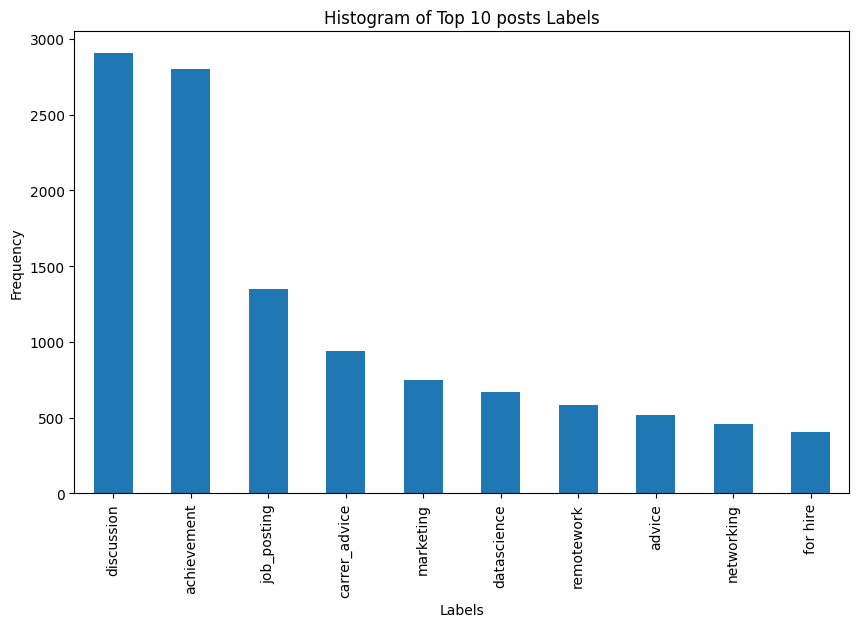

In [0]:
import matplotlib.pyplot as plt

# Split the labels into separate rows
labels_split = profiles_posts_pd['zero_shot_labels'].str.split(',').explode().str.strip()

# Get the top 10 labels
top_10_labels = labels_split.value_counts().nlargest(10)

# Create a histogram
plt.figure(figsize=(10, 6))
top_10_labels.plot(kind='bar')
plt.title('Histogram of Top 10 posts Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

# Cloud Words for profiles_posts

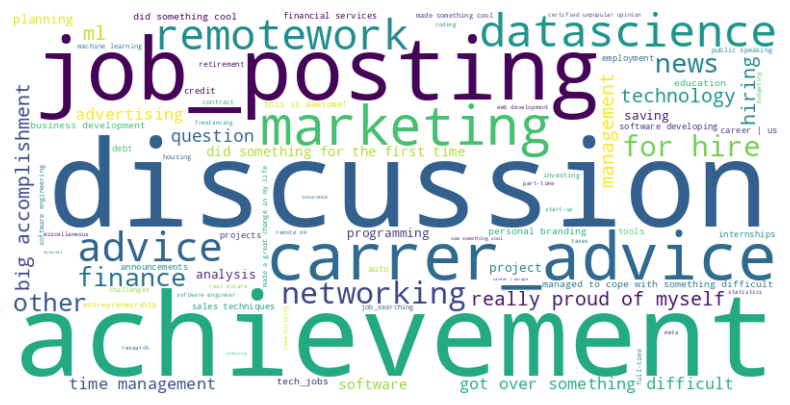

In [0]:
# Get the top 10 labels
top_10_labels = profiles_posts_pd['zero_shot_labels'].str.split(',').explode().str.strip().value_counts()


# Create a word cloud visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_10_labels)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [0]:
companies_posts = companies \
    .where(F.size(F.col('updates')) > 0) \
    .select(F.explode('updates').alias('updates'), 'id') \
    .select('updates.text', 'id') \
    .where(F.col('text').isNotNull() & (F.size(F.split(F.col('text'), ' ')) > 15)) \
  

companies_posts = companies_posts.dropDuplicates(subset=['text']).limit(5000)
companies_posts.display()

# DocumentAssembler: Converts titles into document format
documentAssembler = DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

# UniversalSentenceEncoder: Generate embeddings for entire sentences/titles
use_embeddings = UniversalSentenceEncoder.pretrained("tfhub_use", "en") \
    .setInputCols(["document"]) \
    .setOutputCol("sentence_embeddings")


pipeline = Pipeline(stages=[documentAssembler, use_embeddings])

# Transform the data
companies_posts_embeddings = pipeline.fit(companies_posts).transform(companies_posts).cache()


companies_posts_embeddings = companies_posts_embeddings.select(
    "id", 
    "text", 
    F.col("sentence_embeddings.embeddings").alias("embedding")
)
# Collecting embeddings into a tensor
embeddings_list = companies_posts_embeddings.select("embedding").rdd.map(lambda row: row.embedding[0]).collect()
embeddings_tensor_companies_post = torch.tensor(embeddings_list)

print(f"Embeddings tensor shape: {embeddings_tensor_companies_post.size()}")  # Should now be [num_row_profiles_posts, 512]


from sentence_transformers import util

similarity_matrix_posts_companies = util.cos_sim(embeddings_tensor_companies_post, embeddings_tensor_reddit) 
print(similarity_matrix_posts.shape)

pd.set_option('display.max_colwidth', None)

companies_posts_pd = companies_posts.toPandas()
unified_reddit_pd = unified_reddit.toPandas()
companies_posts_pd['label'] = None
companies_posts_pd['score'] = None
for i in range(len(companies_posts_pd)):
    top_5_indices = similarity_matrix_posts_companies[i].topk(5).indices.tolist()
    top_5_labels = unified_reddit_pd.loc[top_5_indices, 'our_label'].unique()

    # Clean and deduplicate the labels
    cleaned_labels = [word.strip().lower() for words in top_5_labels for word in words.split(',') if word != 'AI']
    unique_labels = sorted(set(cleaned_labels))  # Sort to keep consistent order
    # Assign the cleaned, deduplicated labels and the max score
    companies_posts_pd.loc[i, 'label'] = ', '.join(unique_labels)
 
    companies_posts_pd.loc[i, 'score'] = similarity_matrix_posts_companies[i].max().item()
    
companies_posts_pd.head(5)

from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="syedkhalid076/DeBERTa-Zero-Shot-Classification")

# Function to classify a batch of rows
def classify_batch(batch_titles, batch_labels):
    results = []
    for title, label in zip(batch_titles, batch_labels):
        candidate_labels = label.split(", ") if isinstance(label, str) else []
        result = classifier(title, candidate_labels)
        top_labels = result["labels"][:3]  # Get top 3 labels
        results.append(", ".join(top_labels))
    return results

# Split data into batches
batch_size = 32
titles = companies_posts_pd["text"].tolist()
labels = companies_posts_pd["label"].tolist()
batches = [(titles[i:i + batch_size], labels[i:i + batch_size]) for i in range(0, len(titles), batch_size)]

# Process in batches and collect results
all_results = []
for batch_titles, batch_labels in batches:
    all_results.extend(classify_batch(batch_titles, batch_labels))

# Assign results to the DataFrame
companies_posts_pd["zero_shot_labels"] = all_results
companies_posts_pd.display()

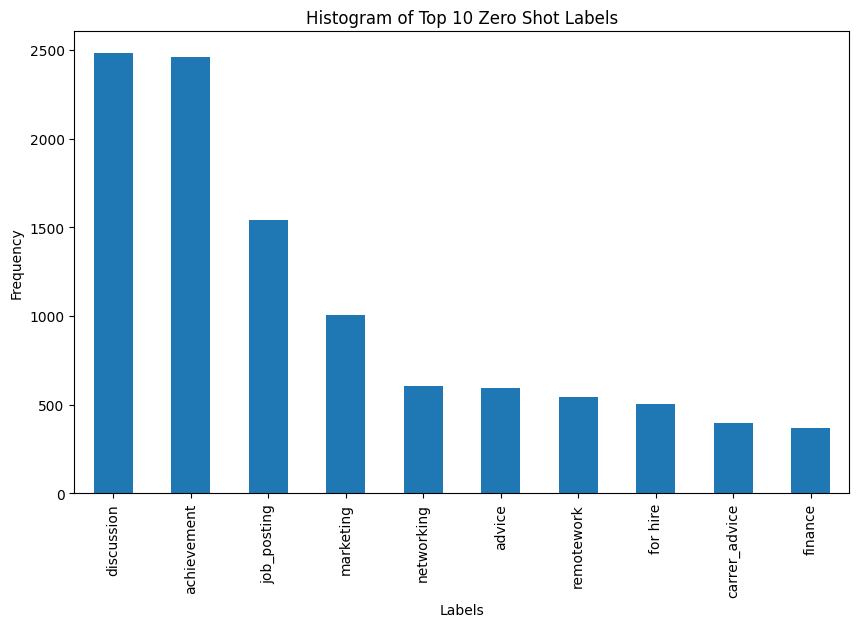

In [0]:
import matplotlib.pyplot as plt

# Split the labels into separate rows
labels_split = companies_posts_pd['zero_shot_labels'].str.split(',').explode().str.strip()

# Get the top 10 labels
top_10_labels = labels_split.value_counts().nlargest(10)

# Create a histogram
plt.figure(figsize=(10, 6))
top_10_labels.plot(kind='bar')
plt.title('Histogram of Top 10 Zero Shot Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

# User Test Location

In [0]:
tags_to_choose = {'remote ok', 'media', 'hiring', 'remotework', 'business development', 'did something cool', 'retirement', 'investing', 'tutorial', 'coding', 'time management', 'personal branding', 'carrer_advice', 'entrepreneurship', 'miscellaneous', 'internships', 'statistics', 'career | asia', 'real estate', 'auto', 'accomplishment', 'de', 'tools', 'challenges', 'project', 'really proud of myself', 'marketing', 'taxes', 'financial services', 'tech_jobs', 'this is awesome!', 'made a great change in my life', 'part-time', 'management', 'ml', 'resources', 'technology', 'someone helped me out', 'employment', 'robotics', 'software developing', 'finance', 'news', 'certified unpopular opinion', 'career | us', 'budgeting', 'machine learning', 'contract', 'achievement', 'did something for the first time', 'for hire', 'web development', 'research', 'closed hiring', 'datascience', 'managed to cope with something difficult', 'made something cool', 'meta', 'team building', 'software engineering', 'education', 'other', 'advice', 'funny/meme', 'advertising', 'debt', 'programming', 'ethics/privacy', 'internet of things', 'sales techniques', 'job_posting', 'computing', 'biotech', 'credit', 'start-up', 'saw something cool', 'monday meme', 'insurance', 'blockchain', 'software engineer', 'public speaking', 'announcements', 'full-time', 'discussion', 'networking', 'freelancing', 'job_searching', 'question', 'projects', 'helped someone else out', 'planning', 'housing', 'analysis', 'career | europe', 'software', 'big accomplishment', 'got over something difficult', 'saving'}

print("Select a tag to filtere the data with:")
print(tags_to_choose)
tag = input()

profiles_posts_pd[profiles_posts_pd['zero_shot_labels'].str.contains(tag)][['title' , 'zero_shot_labels']]

Select a tag to filtere the data with:
{'remote ok', 'managed to cope with something difficult', 'media', 'hiring', 'made something cool', 'meta', 'team building', 'remotework', 'business development', 'software engineering', 'education', 'did something cool', 'other', 'retirement', 'advice', 'investing', 'tutorial', 'funny/meme', 'advertising', 'debt', 'coding', 'programming', 'personal branding', 'time management', 'carrer_advice', 'entrepreneurship', 'miscellaneous', 'ethics/privacy', 'internships', 'internet of things', 'sales techniques', 'statistics', 'career | asia', 'real estate', 'job_posting', 'auto', 'accomplishment', 'computing', 'de', 'biotech', 'tools', 'challenges', 'project', 'really proud of myself', 'marketing', 'taxes', 'financial services', 'tech_jobs', 'this is awesome!', 'credit', 'made a great change in my life', 'start-up', 'part-time', 'management', 'ml', 'resources', 'saw something cool', 'technology', 'monday meme', 'insurance', 'someone helped me out', 'empl

 finance

title                         zero_shot_labels
21                                                                                                            What do you do when you can't find a deal?  finance, made something cool, marketing
29                                                                                                                      Venture Capital in Latin America          investing, finance, achievement
30                                                                                                        West Virginia University Benefits from Peplink         achievement, discussion, finance
39                                                                               You’re Invited – 49th Annual Notre Dame Tax & Estate Planning Institute  finance, job_posting, personal branding
45                                                                                         Children with Autism Enrich the STEM-Focused Economic Sectors             achievement, advice, finance
...                                                                                                                                                  ...                                      ...
5219  OPEN HOUSE Please Join Me Today, Saturday, May 12th, from 1PM till 3PM ! I will have Di Camillo Cookies !!! New Newer Low Price !!! Only $549,900.        finance, job_posting, achievement
5231                                                                                                                                Whitworth Retirement             discussion, finance, housing
5235                                                                                                        Valley Isle Community FCU Financial Literacy         finance, achievement, discussion
5306                                                                                                  Ethics in finance! Make sure they are a fiduciary.      finance, achievement, carrer_advice
5357                                                                                                                           Current FinTech landscape                finance, analysis, saving

[312 rows x 2 columns]

In [0]:
from pyspark.sql import Row

print("Enter user data")
about = input("Enter your about: ")
certifications = input("Enter your certifications: ")
education = input("Enter your education: ")
position = input("Enter your position: ")
posts = input("Enter your posts: ")
courses = input("Enter your courses: ")

user_data = [Row(about=about, certifications=certifications, education=education, position=position, posts=posts, courses=courses)]
user_df = spark.createDataFrame(user_data).withColumn(
        "combined_text",
        F.concat_ws(
           "\n",
           F.col("about"),
           F.col("certifications"),
           F.col("education"),
           F.col("position"),
           F.col("posts"),
           F.col("courses")
        )
    )
user_df = user_df.withColumn('combined_text', remove_stopwords_udf(user_df['combined_text']))

result = col_embeddings(user_df)

# Select the relevant columns to show
result = result.select(
    F.col("user_embeddings.embeddings").alias("embedding_profiles")
)

result = result.where(((F.size(F.col("embedding_profiles")) > 0) & (F.col("combined_text").isNotNull())) & (F.col("combined_text") != ''))
embeddings_list = result.select("embedding_profiles").rdd.map(lambda row: row.embedding_profiles[0]).collect()
embeddings_tensor_users= torch.tensor(embeddings_list)

from sentence_transformers import util

similarity_matrix_posts_profiles = util.cos_sim(embeddings_tensor_users,embeddings_tensor_post) 

result = result.toPandas() # LinkedIn profiles
profiles_posts_pd['top_5_similar'] = None
profiles_posts_pd['score'] = None
for i in range(len(result)):
    top_5_indices = similarity_matrix_posts_profiles[i].topk(5).indices.tolist()
    top_5_labels = profiles_posts_pd.loc[top_5_indices, 'zero_shot_labels'].unique().tolist()
    top_5_posts = profiles_posts_pd.loc[top_5_indices, 'title'].unique().tolist()
    top_5_posters = profiles_posts_pd.loc[top_5_indices, 'id'].tolist()

    # Clean and deduplicate the labels
    cleaned_labels = [word.strip().lower() for words in top_5_labels for word in words.split(', ') if word != 'AI']
    unique_labels = sorted(set(cleaned_labels))  # Sort to keep consistent order
    # Assign the cleaned, deduplicated labels and the max score
    
    result.loc[i, 'suggested_labels'] = ", ".join(unique_labels)
    result.loc[i, 'suggested_post_1'] = top_5_posts[0]
    result.loc[i, 'suggested_post_1_poster'] = top_5_posters[0]
    if len(top_5_posts) >= 2:
        result.loc[i, 'suggested_post_2'] = top_5_posts[1]
        result.loc[i, 'suggested_post_2_poster'] = top_5_posters[1]
    if len(top_5_posts) >= 3:
        result.loc[i, 'suggested_post_3'] = top_5_posts[2]
        result.loc[i, 'suggested_post_3_poster'] = top_5_posters[2]
    if len(top_5_posts) >= 4:
        result.loc[i, 'suggested_post_4'] = top_5_posts[3]
        result.loc[i, 'suggested_post_4_poster'] = top_5_posters[3]
    if len(top_5_posts) >= 5:
        result.loc[i, 'suggested_post_5'] = top_5_posts[4]
        result.loc[i, 'suggested_post_5_poster'] = top_5_posters[4]


 
    profiles_posts_pd.loc[i, 'score'] = similarity_matrix_posts_profiles[i].max().item()

result[['suggested_post_1', 'suggested_post_1_poster', 'suggested_post_2', 'suggested_post_2_poster', 'suggested_post_3', 'suggested_post_3_poster', 'suggested_post_4', 'suggested_post_4_poster', 'suggested_post_5', 'suggested_post_5_poster', 'suggested_labels']].head(5)

# print(similarity_matrix_posts_profiles.shape)
# print(f"Embeddings tensor shape: {embeddings_tensor_users.size()}")
# display(user_df)

Enter user data


Enter your about:  i love data science

Enter your certifications:  

Enter your education:  

Enter your position:  software engineer

Enter your posts:  

Enter your courses:  ai

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


suggested_post_1      suggested_post_1_poster                                   suggested_post_2 suggested_post_2_poster                                           suggested_post_3 suggested_post_3_poster                                      suggested_post_4 suggested_post_4_poster           suggested_post_5 suggested_post_5_poster                                                                                           suggested_labels
0  Importance of Software Skills in Data Analytics:  prakash-tamminedi-400b8b156  ​Is big data analytics really the next big thing?   sakshi-arora-48935b12  Psychology and AI Research via Computer Mind Simulations.   john-coleman-8a2a6770  Artificial Intelligence Computer Vision in Logistics  craigsmithredrockgroup  Smart Data statt Big Data               yussipick  achievement, carrer_advice, discussion, job_posting, managed to cope with something difficult, management